# Predict Turbofan Degradation

In this example, we build a machine learning application to predict turbofan engine degradation. This application is structured into three important steps:

* Prediction Engineering
* Feature Engineering
* Machine Learning

In the first step, we generate new labels from the data by using [Compose](https://compose.alteryx.com/). In the second step, we generate features for the labels by using [Featuretools](https://docs.featuretools.com/). In the third step, we search for the best machine learning pipeline by using [EvalML](https://evalml.alteryx.com/). 
After working through these steps, you will learn how to build machine learning applications for real-world problems like predictive maintenance. Let's get started.

In [1]:
from demo.turbofan_degredation import load_sample
from matplotlib.pyplot import subplots
import composeml as cp
import featuretools as ft
import evalml

2020-09-04 17:08:35,618 featuretools - WARNING    Featuretools failed to load plugin autonormalize from library autonormalize. For a full stack trace, set logging to debug.
2020-09-04 17:08:35,691 featuretools - WARNING    Featuretools failed to load plugin tsfresh from library featuretools_tsfresh_primitives.__init__. For a full stack trace, set logging to debug.
2020-09-04 17:08:35,783 featuretools - WARNING    Featuretools failed to load plugin nlp_primitives from library nlp_primitives. For a full stack trace, set logging to debug.


We will use a dataset provided by [NASA](https://www.kaggle.com/behrad3d/nasa-cmaps) simulating turbofan engine degradation. In this dataset, we have engines which are monitored over time. Each engine had operational settings and sensor measurements recorded for each cycle. The remaining useful life (RUL) is the amount of cycles an engine has left before it needs maintenance. What makes this dataset special is that the engines run all the way until failure, giving us precise RUL information for every engine at every point in time. 

In [2]:
df = load_sample()
df.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,time
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,2000-01-01 00:40:00


## Prediction Engineering

> Which range is the RUL of a turbofan engine in?

In this prediction problem, we want to group the RUL into ranges. Then, predict which range the RUL is in. We can make variations of the ranges to create different prediction problems. For example, the ranges can be manually defined (0 - 150, 150 - 300, etc.) or based on the quartiles from historical observations. These variations can be done by simply binning the RUL. This helps us explore different scenarios which is crucial for making better decisions.

### Defining the Labeling Function

Let's start by defining the labeling function of an engine that calculates the RUL. Given that engines run all the way until failure, the RUL is just the remaining number of observations. Our labeling function will be used by a label maker to extract the training examples.

In [3]:
def rul(ds):
    return len(ds) - 1

### Representing the Prediction Problem

Then, let's represent the prediction problem by creating a label maker with the following parameters:

* The `target_entity` as the column for the engine ID, since we want to process records for each engine.
* The `labeling_function` as the function we defined previously.
* The `time_index` as the column for the event time.

In [4]:
lm = cp.LabelMaker(
    target_entity='engine_no',
    labeling_function=rul,
    time_index='time',
)

### Finding the Training Examples

Now, let's run a search to get the training examples by using the following parameters:

* The records sorted by the event time, since the search will expect the records to be sorted chronologically, otherwise an error will be raised.
* `num_examples_per_instance` as the number of training examples to find for each engine.
* `minimum_data` as the amount of data that will be used to make features for the first training example.  
* `gap` as the number of rows to skip between examples. This is done to cover different points in time of an engine.

We can easily tweak these parameters and run more searches for training examples as the requirements of our model changes.

In [5]:
lt = lm.search(
    df.sort_values('time'),
    num_examples_per_instance=20,
    minimum_data=5,
    gap=20,
    verbose=False,
)

lt.head()

,engine_no,time,rul
0,1,2000-01-01 00:50:00,315
1,1,2000-01-01 04:10:00,295
2,1,2000-01-01 07:30:00,275
3,1,2000-01-01 10:50:00,255
4,1,2000-01-01 14:10:00,235


The output from the search is a label times table with three columns:

* The engine ID associated to the records. There can be many training examples generated from each engine.
* The event time of the engine. This is also known as a cutoff time for building features. Only data that existed beforehand is valid to use for predictions.
* The value of the RUL. This is calculated by our labeling function.

At this point, we only have continuous values of the RUL. As a helpul reference, we can print out the search settings that were used to generate these labels.

In [6]:
lt.describe()

Settings
--------
gap                                  20
minimum_data                          5
num_examples_per_instance            20
target_column                       rul
target_entity                 engine_no
target_type                  continuous
window_size                        None


Transforms
----------
No transforms applied



We can also get a better look at the values by plotting the distribution and the cumulative count across time.

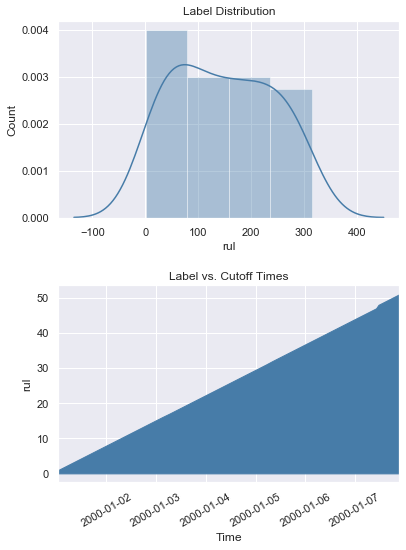

In [7]:
%matplotlib inline
fig, ax = subplots(nrows=2, ncols=1, figsize=(6, 8))
lt.plot.distribution(ax=ax[0])
lt.plot.count_by_time(ax=ax[1])
fig.tight_layout(pad=2)

With the continuous values, we can explore different ranges without running the search again. In this case, we will just use quartiles to bin the values into ranges.

In [8]:
lt = lt.bin(4, quantiles=True, precision=0)

When we print out the settings again, we can now see that the description of the labels has been updated and reflects the latest changes.

In [9]:
lt.describe()

Label Distribution
------------------
(0.0, 64.0]       13
(141.0, 227.0]    12
(227.0, 315.0]    13
(64.0, 141.0]     13
Total:            51


Settings
--------
gap                                 20
minimum_data                         5
num_examples_per_instance           20
target_column                      rul
target_entity                engine_no
target_type                   discrete
window_size                       None


Transforms
----------
1. bin
  - bins:            4
  - labels:       None
  - precision:       0
  - quantiles:    True
  - right:        True



Let's have a look at the new label distribution and cumulative count across time.

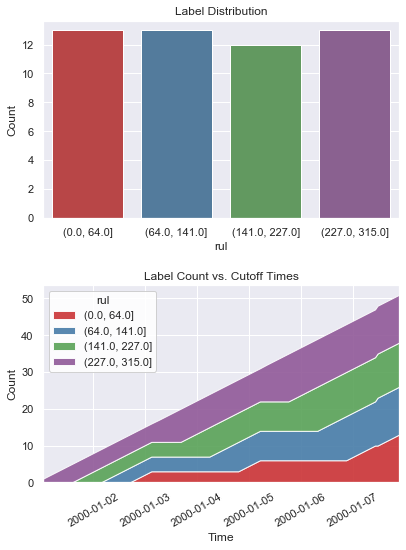

In [10]:
fig, ax = subplots(nrows=2, ncols=1, figsize=(6, 8))
lt.plot.distribution(ax=ax[0])
lt.plot.count_by_time(ax=ax[1])
fig.tight_layout(pad=2)

## Feature Engineering

In the previous step, we generated the labels. The next step is to generate the features.

### Representing the Data

Let's start by representing the data with an entity set. This way, we can generate features based on the relational structure of the dataset. We currently have a single table of records where one engine can have many records. This one-to-many relationship can be represented by normalizing an engine entity. The same can be done for other one-to-many relationships. We want to make predictions based on the engine, so we will use this engine entity as the target entity for generating features.

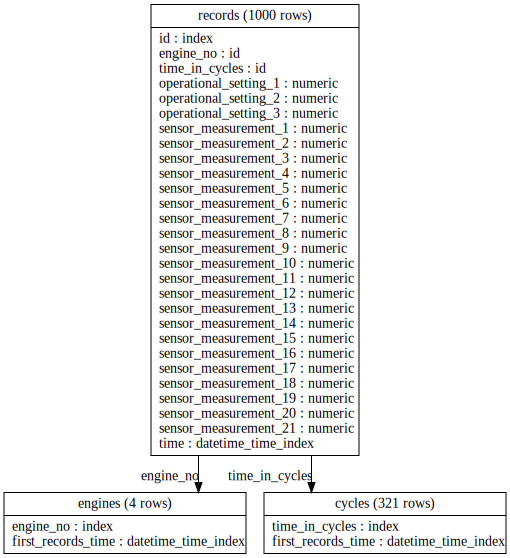

In [11]:
es = ft.EntitySet('observations')

es.entity_from_dataframe(
    dataframe=df.reset_index(),
    entity_id='records',
    index='id',
    time_index='time',
)

es.normalize_entity(
    base_entity_id='records',
    new_entity_id='engines',
    index='engine_no',
)

es.normalize_entity(
    base_entity_id='records',
    new_entity_id='cycles',
    index='time_in_cycles',
)

es.plot()

### Calculating the Features

Now, we can generate features by using a method called Deep Feature Synthesis (DFS). This will automatically build features by stacking and applying mathematical operations called primitives across relationships in an entity set. The more structured an entity set is, the better DFS can leverage the relationships to generate better features. Let’s run DFS using the following parameters:

* `entity_set` as the entity set we structured previously.
* `target_entity` as the engine entity.
* `cutoff_time` as the label times that we generated previously. The label values are appended to the feature matrix.

In [12]:
fm, fd = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['sum'],
    trans_primitives=[],
    cutoff_time=lt,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=False,
)

fm.head()

SUM(records.operational_setting_1)  \
engine_no time                                                      
1         2000-01-01 00:50:00                            171.0170   
          2000-01-01 04:10:00                            639.0537   
          2000-01-01 07:30:00                           1128.1028   
          2000-01-01 10:50:00                           1600.1473   
          2000-01-01 14:10:00                           2134.2039   

                               SUM(records.operational_setting_2)  \
engine_no time                                                      
1         2000-01-01 00:50:00                              3.8418   
          2000-01-01 04:10:00                             15.8218   
          2000-01-01 07:30:00                             28.0260   
          2000-01-01 10:50:00                             39.2949   
          2000-01-01 14:10:00                             51.8739   

                               SUM(records.operational_setting_3)  \
engine_no time                                                      
1         2000-01-01 00:50:00                               460.0   
          2000-01-01 04:10:00                              2300.0   
          2000-01-01 07:30:00                              4060.0   
          2000-01-01 10:50:00                              5980.0   
          2000-01-01 14:10:00                              7940.0   

                               SUM(records.sensor_measurement_1)  \
engine_no time                                                     
1         2000-01-01 00:50:00                            2288.73   
          2000-01-01 04:10:00                           11809.97   
          2000-01-01 07:30:00                           21211.42   
          2000-01-01 10:50:00                           30722.92   
          2000-01-01 14:10:00                           40118.03   

                               SUM(records.sensor_measurement_10)  \
engine_no time                                                      
1         2000-01-01 00:50:00                                5.04   
          2000-01-01 04:10:00                               26.48   
          2000-01-01 07:30:00                               47.58   
          2000-01-01 10:50:00                               69.59   
          2000-01-01 14:10:00                               91.37   

                               SUM(records.sensor_measurement_11)  \
engine_no time                                                      
1         2000-01-01 00:50:00                              205.45   
          2000-01-01 04:10:00                             1049.86   
          2000-01-01 07:30:00                             1874.82   
          2000-01-01 10:50:00                             2734.53   
          2000-01-01 14:10:00                             3591.92   

                               SUM(records.sensor_measurement_12)  \
engine_no time                                                      
1         2000-01-01 00:50:00                              865.90   
          2000-01-01 04:10:00                             6212.29   
          2000-01-01 07:30:00                            11083.94   
          2000-01-01 10:50:00                            16627.16   
          2000-01-01 14:10:00                            21653.49   

                               SUM(records.sensor_measurement_13)  \
engine_no time                                                      
1         2000-01-01 00:50:00                            11579.79   
          2000-01-01 04:10:00                            57897.83   
          2000-01-01 07:30:00                           103495.65   
          2000-01-01 10:50:00                           150532.67   
          2000-01-01 14:10:00                           197930.92   

                               SUM(records.sensor_measurement_14)  \
engine_no time                                                      
1         2000-01-01 00:50:0


There are two outputs from DFS: a feature matrix and feature definitions. The feature matrix is a table that contains the feature values with the corresponding labels based on the cutoff times. Feature definitions are features in a list that can be stored and reused later to calculate the same set of features on future data.

## Machine Learning

In the previous steps, we generated the labels and features. The final step is to build the machine learning pipeline.

### Splitting the Data

Let's start by extracting the labels from the feature matrix and splitting the data into a training set and a holdout set.

In [13]:
y = fm.pop('rul').cat.codes

splits = evalml.preprocessing.split_data(
    X=fm,
    y=y,
    test_size=0.2,
    random_state=0,
)

X_train, X_holdout, y_train, y_holdout = splits

### Finding the Best Model

Then, let's run a search on the training set for the best machine learning model. During the search process, predictions from several different pipelines are evaluated to find the best pipeline.

In [14]:
automl = evalml.AutoMLSearch(
    problem_type='multiclass',
    objective='f1_macro',
)

automl.search(
    X_train,
    y_train,
    data_checks='disabled',
    show_iteration_plot=False,
)

Using default limit of max_pipelines=5.

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for F1 Macro. 
Greater score is better.

Searching up to 5 pipelines. 
Allowed model families: xgboost, extra_trees, linear_model, random_forest, catboost

(1/5) Mode Baseline Multiclass Classificati... Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.092
(2/5) Extra Trees Classifier w/ Imputer        Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.735
(3/5) Elastic Net Classifier w/ Imputer + S... Elapsed:00:02
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.190
(4/5) CatBoost Classifier w/ Imputer           Elapsed:00:02
	Starting cross validation
	Finished cross validation - mean F1 Macro: 0.839
(5/5) XGBoost Classifier w/ Imputer            Elapsed:00:03
	Starting cross validation
	Finished cross valida

Once the search is complete, we can print out information about the best pipeline found, such as the parameters in each component. 

**********************************
* CatBoost Classifier w/ Imputer *
**********************************

Problem Type: Multiclass Classification
Model Family: CatBoost

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. CatBoost Classifier
	 * n_estimators : 10
	 * eta : 0.03
	 * max_depth : 6
	 * bootstrap_type : None


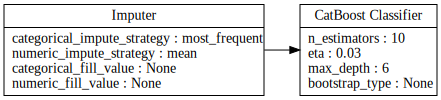

In [15]:
automl.best_pipeline.describe()
automl.best_pipeline.graph()

Let's score the model performance by evaluating predictions on the holdout set.

In [16]:
best_pipeline = automl.best_pipeline.fit(X_train, y_train)

score = best_pipeline.score(
    X=X_holdout,
    y=y_holdout,
    objectives=['f1_macro'],
)

dict(score)

{'F1 Macro': 0.8142857142857144}

From the pipeline, we can see which features are most important for predictions.

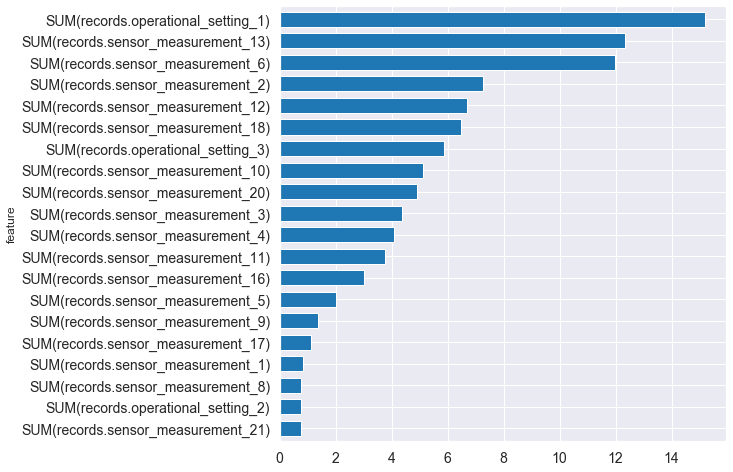

In [17]:
feature_importance = best_pipeline.feature_importance
feature_importance = feature_importance.set_index('feature')['importance']
top_k = feature_importance.abs().sort_values().tail(20).index
feature_importance[top_k].plot.barh(figsize=(8, 8), fontsize=14, width=.7);

### Making Predictions

We are ready to make predictions with our trained model. First, let's calculate the same set of features by using the feature definitions. We will use a cutoff time based on the latest information available in the dataset.

In [18]:
fm = ft.calculate_feature_matrix(
    features=fd,
    entityset=es,
    cutoff_time=ft.pd.Timestamp('2001-01-08'),
    cutoff_time_in_index=True,
    verbose=False,
)

fm.head()

,,SUM(records.operational_setting_1),SUM(records.operational_setting_2),SUM(records.operational_setting_3),SUM(records.sensor_measurement_1),SUM(records.sensor_measurement_10),SUM(records.sensor_measurement_11),SUM(records.sensor_measurement_12),SUM(records.sensor_measurement_13),SUM(records.sensor_measurement_14),SUM(records.sensor_measurement_15),...,SUM(records.sensor_measurement_2),SUM(records.sensor_measurement_20),SUM(records.sensor_measurement_21),SUM(records.sensor_measurement_3),SUM(records.sensor_measurement_4),SUM(records.sensor_measurement_5),SUM(records.sensor_measurement_6),SUM(records.sensor_measurement_7),SUM(records.sensor_measurement_8),SUM(records.sensor_measurement_9)
engine_no,time,,,,,,,,,,,,,,,,,,,,,
1,2001-01-08,7844.8251,187.1480,29900.0,151437.54,349.31,13621.32,83433.63,746768.22,2586414.19,2989.1171,...,185203.96,6564.32,3939.3839,451472.15,381250.77,2536.56,3642.99,88655.01,712119.21,2727253.88
2,2001-01-08,7150.7632,172.3969,27900.0,141454.77,326.01,12790.85,79218.75,696035.77,2408732.69,2796.9249,...,173148.42,6209.87,3724.1262,423347.79,358817.21,2405.32,3465.92,84157.26,664687.46,2544643.76
3,2001-01-08,7383.8145,176.3420,28540.0,145064.24,336.11,13094.61,81344.80,713749.97,2477368.02,2844.1535,...,177419.00,6376.53,3827.9730,433590.30,367007.35,2454.07,3528.60,86413.34,681192.20,2614296.72
4,2001-01-08,1656.2282,40.1501,6860.0,34753.89,80.43,3143.91,20356.87,170371.56,588797.05,678.7739,...,42587.33,1586.78,951.7593,104211.31,88460.82,612.45,885.21,21619.23,163214.91,624223.64


Now, let's predict which one of the four ranges the RUL is in.

In [19]:
values = best_pipeline.predict(fm).values

prediction = fm[[]]
prediction['rul (estimate)'] = values
prediction.head()

,,rul (estimate)
engine_no,time,
1,2001-01-08,0
2,2001-01-08,0
3,2001-01-08,0
4,2001-01-08,3


### Next Steps

At this point, we have completed the machine learning application. We can revisit each step to explore and fine-tune with different parameters until the model is ready for deployment. For more information on how to work with the features produced by Featuretools, take a look at [the Featuretools documentation](https://docs.featuretools.com/). For more information on how to work with the models produced by EvalML, take a look at [the EvalML documentation](https://evalml.alteryx.com/).